```{index} single: application; fleet assignment
```
```{index} single: solver; HiGHS
```
```{index} pandas dataframe
```
```{index} single: Pyomo; parameters
```
```{index} single: Pyomo; sets
```
```{index} single: Pyomo; expressions
```
```{index} simulations
```
```{index} networkx
```
```{index} Gantt charts
```

# 7.1 Fleet assignment problem

## Problem description

Given a set of flights to be flown, an airline company needs to determine the specific route flown by each airplane in the most cost-effective way. Clearly, the airline company should try to use as fewer airplanes as possible, but the same airplane can operate two subsequent flights only if the time interval between the arrival of the first flight and the departure of the next flight is longer than or equal to one hour.

The task of the airline operations team is to determine the minimum number of airplanes needed to operate the given list of flights. This problem is known as the **fleet assignment problem** or **aircraft rotation problem**. We are going to consider the simplest version of the problem where all the of the $M$ available airplanes are assumed to be identical.

## Preamble: Install Pyomo and a solver

The following cell sets and verifies a global SOLVER for the notebook. If run on Google Colab, the cell installs Pyomo and the HiGHS solver, while, if run elsewhere, it assumes Pyomo and HiGHS have been previously installed. It then sets to use HiGHS as solver via the appsi module and a test is performed to verify that it is available. The solver interface is stored in a global object `SOLVER` for later use.

In [22]:
import sys
 
if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null
 
solver = 'appsi_highs'
 
import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

## Generate Flight Data

In [33]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from numpy.random import RandomState


# python generator creates departure and arrival times for a single airport
def generate_flights(
    N_flights=30, min_duration=1, max_duration=4, max_departure=24, seed=0
):
    rs = RandomState(seed)
    for flight in range(N_flights):
        end_flight = max_departure + 1
        while end_flight > max_departure:
            start_flight = np.floor(max_departure * rs.rand())
            end_flight = start_flight + 3 * np.ceil(
                (max_duration + 1 - min_duration) * rs.rand()
            )
        yield flight, int(start_flight), int(end_flight)


# generate flight data
FlightData = pd.DataFrame(
    [[flight, departure, arrival] for flight, departure, arrival in generate_flights()]
)
FlightData.columns = ["Flight", "Departure", "Arrival"]
FlightData.set_index("Flight", inplace=True)
FlightData

,Departure,Arrival
Flight,,
0,13,22
1,14,23
2,10,19
3,10,22
4,1,4
5,0,12
6,11,23
7,2,11
8,3,15


## Visualize Flight Data

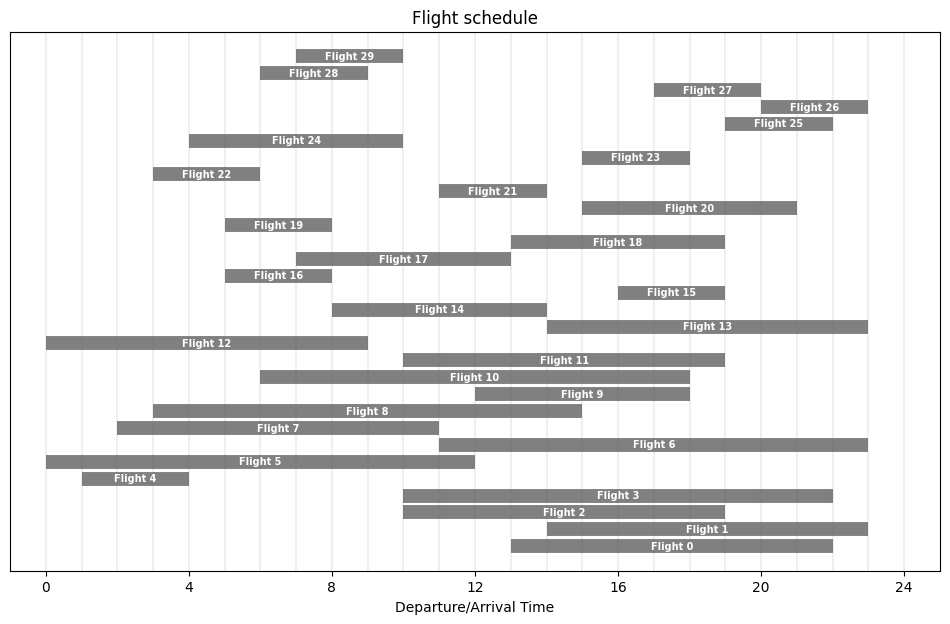

In [34]:
# visualize flight data
def draw_flights(FlightData):
    bar_style = {"alpha": 1.0, "lw": 10, "solid_capstyle": "butt"}
    text_style = {
        "fontsize": 7,
        "color": "white",
        "weight": "bold",
        "ha": "center",
        "va": "center",
    }
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111, xlabel="Departure/Arrival Time", title="Flight schedule")
    ax.get_yaxis().set_visible(False)
    for flight, row in FlightData.iterrows():
        departure, arrival = row
        ax.plot([departure, arrival], [flight] * 2, "gray", **bar_style)
        ax.text((departure + arrival) / 2, flight, f"Flight {flight}", **text_style)
    for hr in range(25):
        ax.axvline(hr, alpha=0.1)
    ax.set_xlim(-1, 25)
    ax.set_xticks([4 * i for i in range(7)])
    return ax


ax = draw_flights(FlightData)

## Pyomo Model

The fleet assignment problem can be formulated and solved as an MILO problem. The idea of the MILO problem formulation is to construct feasible paths in a directed graph where the flights are nodes with indices $\mathcal{F} = \left\{ 1, \ldots, F \right\}$. The set of arcs $\mathcal{A} \subseteq \mathcal{F} \times \mathcal{F}$ that can be used by each aircraft is then:

$$
\mathcal{A} = \{ (f_1, f_2) \ : \ f_1 \text{ arrives at least 1h before the departure of } f_2 \}.
$$

The following cell finds the set of arcs that can be used. These arcs are displayed in a graph of the flight data. Arcs corresponding to the minimum time between arrival and departure are highlighted in red.

In [35]:
min_time = 1


def feasible_flight_pairs(FlightData, min_time=1):
    # return a dictionary of turnaound times index by flight pairs
    turnaround = (
        lambda pair: FlightData.loc[pair[1], "Departure"]
        - FlightData.loc[pair[0], "Arrival"]
    )
    pairs = filter(
        lambda pair: turnaround(pair) >= min_time,
        [(i, j) for i in FlightData.index for j in FlightData.index if i != j],
    )
    return {pair: turnaround(pair) for pair in pairs}


flight_pairs = feasible_flight_pairs(FlightData).keys()

The following cell presents a visualization of the graph of feasible paths in which an aircraft can be reassigned from one flight to subsequent flight. Each node on the graph corresponds to a flight. An edge from flight $f_1$ to flight $f_2$ is included only if there is at least `min_time` hours available to `turn around` the aircraft. Edges that allow exactly `min_time` hours between flights are colored red because these will be the most affected by unexpected flight delays.

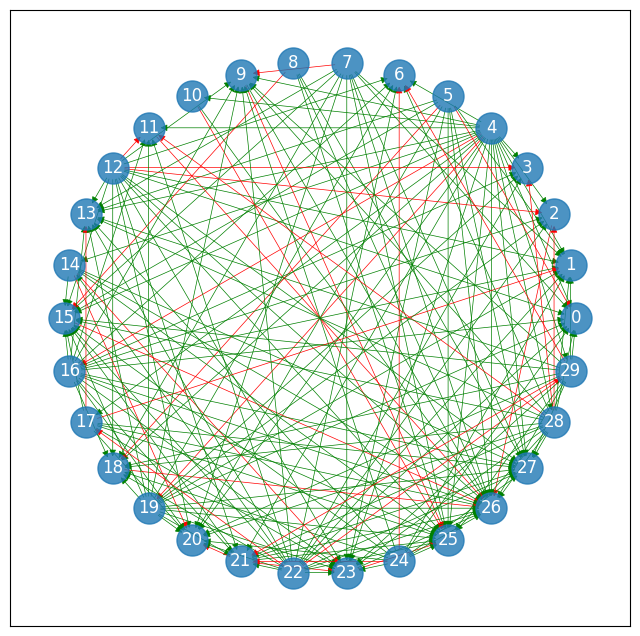

In [36]:
dg = nx.DiGraph()

for flight in FlightData.index:
    _ = dg.add_node(flight)

for pair, dur in feasible_flight_pairs(FlightData).items():
    _ = dg.add_edge(pair[0], pair[1], color="r" if dur <= min_time else "g")

size = int(1.5 * np.sqrt(len(FlightData)))
fig = plt.figure(figsize=(size, size))
pos = nx.circular_layout(dg)
nx.draw_networkx_nodes(dg, pos=pos, node_size=500, alpha=0.8)
nx.draw_networkx_labels(dg, pos=pos, font_color="w")
nx.draw_networkx_edges(
    dg, pos=pos, width=0.5, edge_color=[dg.edges[u, v]["color"] for u, v in dg.edges]
)
plt.show()

### Naive model formulation

An idea of an MILO formulation of the problem is to construct a feasible path for each aircraft in a graph where the flights are nodes with indices $1, \ldots, F$, and there is one source node $0$ and a sink node $F + 1$. The set of arcs $\mathcal{A}'$ that can be used by each aircraft is then:

$$
\mathcal{A'} = 
\bigcup_{f_1,f_2 \in \mathcal{F}} \{ (f_1, f_2) ~:~ f_1 \text{ arrives at least 1h before departure of } f_2 \} \cup \bigcup_{f \in \mathcal{F}}  \{ (0, f), \ (f, F+1)\}
$$

where $0$ and $F + 1$ play the role of dummy flights before the first/after the last flight of a given aircraft's assignment.

Denote the set of aircraft indices as $\mathcal{M} = \{ 1, \ldots, M\}$. The decision variables then are:
- $x_{f_1, f_2, i} \in \{0, 1\}$, $a \in \mathcal{A}'$, $i \in \mathcal{M}$ indicating whether the connection $(f_1, f_2) = a$ is operated by aircraft $i$
- $y_i \in \{0, 1\}$, for $i \in \mathcal{M}$ indicating whether aircraft $i$ is used or not

The corresponding MILO problem is then:

$$
\begin{align}
    \min \quad & \sum\limits_{i \in \mathcal{M}} y_i \tag{a}\\
    \text{s.t.} \quad 
    & \sum\limits_{f_1 \in \mathcal{F} \cup \{ 0, F+1\} ~:~ (f_1, f) \in \mathcal{A}'} x_{f_1, f, i} = \sum\limits_{h \in \mathcal{F} \cup \{ 0, F+1\} ~:~ (f, f_2) \in \mathcal{A}'} x_{f, f_2, i} & \forall \, f \in \mathcal{F}, \ \forall \, i \in \mathcal{M} \tag{b}\\
    & \sum\limits_{i \in \mathcal{M}} \sum\limits_{f' \in \mathcal{F} \cup \{ 0, F+1\} ~:~ (f', f) \in \mathcal{A}'} x_{f', f, i} = 1 & \forall \, f \in \mathcal{F} \tag{c}\\
    & \sum\limits_{(0, f) \in \mathcal{A}'} x_{0, f, i} \leq 1 & \forall \, i \in \mathcal{M} \tag{d}\\
    & x_{f, 0, i} \leq y_i & \forall \, f \in \mathcal{F}, \ \forall \, i \in \mathcal{M} \tag{e}\\
    & x_{a, i} \in \{0,1\} & \forall \, a \in \mathcal{A}', i \in \mathcal{M} \tag{f}\\
    & y_i \in \{0,1\} & \forall \, i \in \mathcal{M} \tag{g}
\end{align}
$$

where
- the objective function (a) aims to minimize the number of airplanes used;
- constraint (b) enforces that for a given real flight the number of used incoming arcs with airplane $i$ must be equal to the number of outgoing arcs with this airplane;
- constraint (c) ensures that each flight is operated by exactly one aircraft;
- constraint (d) enforces that each airplane serves at most one sequence of flights;
- constraint (e) ensures that if at least one arc $(f, 0)$ is used using a given airplane, then this airplane is used;
- constraints (f) and (g) are the integrality constraints.

This formulation is very explicit and each decision there clearly corresponds to a real-life decision. However, it has a drawback -- it is blind to the aircraft being all identical. Consider a situation where aircraft $1$ is assigned to operate flights $(1, 2, 3)$ and aircraft $2$ is assigned to operate flights $(4, 5)$. Then, one can simply swap the flight assignment of the two aircraft between them and arrive at another solution is essentially the same if the aircraft are all identical. In terms of mathematical optimization, this means that the problem has a lot of *symmetry* which produces a huge solution space that the solving algorithm has to explore. 

A normal practice is to eliminate symmetry from the problem, for example, by adding so-called *symmetry-breaking constraints* that do not change the problem but allow only one out of many equivalent solutions. Here, one such constraint would be

$$
\begin{align*}
y_i \leq y_{i - 1} & \qquad \forall \, i \in \mathcal{M}: \ i > 0,
\end{align*}
$$

which would ensure, at least, that we utilize airplanes in the order they appear on the list, i.e., aircraft $2$ cannot be used if aircraft $1$ was not used. However, an even better way of removing symmetry from the problem is to remove the airplanes from the model altogether.

### Symmetry-free and totally-unimodular model formulation

In the next model we only create flight combinations to be operated by a single aircraft and assign the actual aircraft in a post-processing step. First, for each node $f\in\mathcal{F}$ in the DiGraph we define a set of input nodes $\mathcal{I}_f = \{f_1: (f_1, f)\in\mathcal{A}\}$  and a set of output nodes $\mathcal{O}_f = \{f_1: (f, f_1)\in\mathcal{A} \}$. For this application, we use the Python ``set`` object to scan the feasible flight pairs and find the inputs and outputs nodes for each flight node. 

In [37]:
in_nodes = {flight: set() for flight in FlightData.index}
out_nodes = {flight: set() for flight in FlightData.index}

for flight1, flight2 in flight_pairs:
    in_nodes[flight2].add(flight1)
    out_nodes[flight1].add(flight2)

The decision variables are:

* $x_{f_1, f_2}\in\{0,1\}$ for all $(f_1, f_2) \in\mathcal{A}$ where $x_{f_1, f_2} = 1$ indicates that an aircraft used for arriving flight $f_1$ will used for departing flight $f_2$.

* $p_f\in\{0,1\}$ for all $f\in\mathcal{F}$ where $p_f = 1$ indicates a previously unassigned aircraft will be use for departing flight $f$.

* $q_f\in\{0,1\}$ for all $f\in\mathcal{F}$ where $q_f = 1$ indicates an aircraft will be unassigned after arrival of flight $f$.

The binary variables $p_f$ and $q_f$ correspond to arcs that link nodes to the sources and sinks of aircraft needed to complete all of the flights $f\in\mathcal{F}$. The objective is to minimize the number of required aircraft subject to the constraints that exactly one aircraft is a assigned to and released from each node.

$$\begin{align}
\min \quad & \sum_{f\in\mathcal{F}} p_f \\
\text{s.t.}\quad & p_f + \sum_{f_1\in\mathcal{I}_f} x_{f_1, f} = 1 & \forall f\in\mathcal{F} \\
& q_f + \sum_{f_1\in\mathcal{O}_f} x_{f, f_1} = 1 & \forall f\in\mathcal{F} \\
& x_{f_1, f_2}, p_f, q_f \in \{ 0, 1\} & \forall f, f_1, f_2 \in \mathcal{F}
\end{align}$$

This model will give solutions where decisions $x_{f_1, f_2}$ will yield paths corresponding to sequences of flights that can be operated with a single aircraft. To such paths, we can assign aircraft in an arbitrary fashion after the optimization is finished.

As it turns out, for this model formulation it is also easy to verify using the tools of Chapter 4 that the corresponding matrix formulation of the model is **totally unimodular**. That means, it is possible to eliminate the integrality restriction on the decision variables (keeping the $[0, 1]$ interval bounds) to arrive at an LO model that yields integral solutions without explicitly requiring it.

For that reason, we are going to use this model formulation in our further analysis.

In [38]:
m = pyo.ConcreteModel("Fleet Assignment")

m.FLIGHTS = pyo.Set(initialize=FlightData.index)
m.PAIRS = pyo.Set(initialize=flight_pairs)

m.x = pyo.Var(m.PAIRS, domain=pyo.Binary)
m.p = pyo.Var(m.FLIGHTS, domain=pyo.Binary)
m.q = pyo.Var(m.FLIGHTS, domain=pyo.Binary)


@m.Constraint(m.FLIGHTS)
def sources(m, flight):
    return m.p[flight] + sum(m.x[_, flight] for _ in in_nodes[flight]) == 1


@m.Constraint(m.FLIGHTS)
def sinks(m, flight):
    return m.q[flight] + sum(m.x[flight, _] for _ in out_nodes[flight]) == 1


@m.Objective(sense=pyo.minimize)
def minimize_airplanes(m):
    return pyo.summation(m.p)


SOLVER.solve(m)

print(f"Minimum airplanes required = {m.minimize_airplanes()}")

Minimum airplanes required = 14.0


We visualize the solution by redrawing the graph of possible path and highlighting the edges that have been selected for aircraft reassignment. 

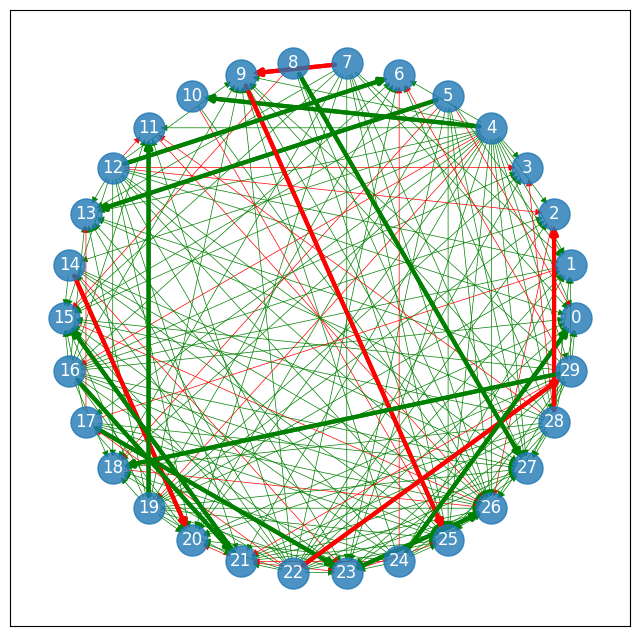

In [39]:
dg_soln = nx.DiGraph()

for flight in FlightData.index:
    dg_soln.add_node(flight)

for pair, dur in feasible_flight_pairs(FlightData).items():
    if m.x[pair[0], pair[1]].value == 1:
        dg_soln.add_edge(pair[0], pair[1], color="r" if dur <= min_time else "g")

size = int(1.5 * np.sqrt(len(FlightData)))
fig = plt.figure(figsize=(size, size))

nx.draw_networkx_nodes(dg_soln, pos=pos, node_size=500, alpha=0.8)
nx.draw_networkx_labels(dg_soln, pos=pos, font_color="w")
nx.draw_networkx_edges(
    dg_soln,
    pos=pos,
    width=3,
    edge_color=[dg_soln.edges[u, v]["color"] for u, v in dg_soln.edges],
)
nx.draw_networkx_edges(
    dg, pos=pos, width=0.5, edge_color=[dg.edges[u, v]["color"] for u, v in dg.edges]
)
nx.draw_networkx_edges(
    dg_soln,
    pos=pos,
    width=3,
    edge_color=[dg_soln.edges[u, v]["color"] for u, v in dg_soln.edges],
)
plt.show()

We visualize the solution by drawing arcs where $x_{f_1, f_2} = 1$ and where $p_f = 1$ and $q_f = 1$. These arcs draw feasible paths through the graph corresponding to the assignment of one aircraft to service one or more flights. The arcs are green if the time between the two flights is strictly larger the minimum layover time (1h) and red if it is equal.

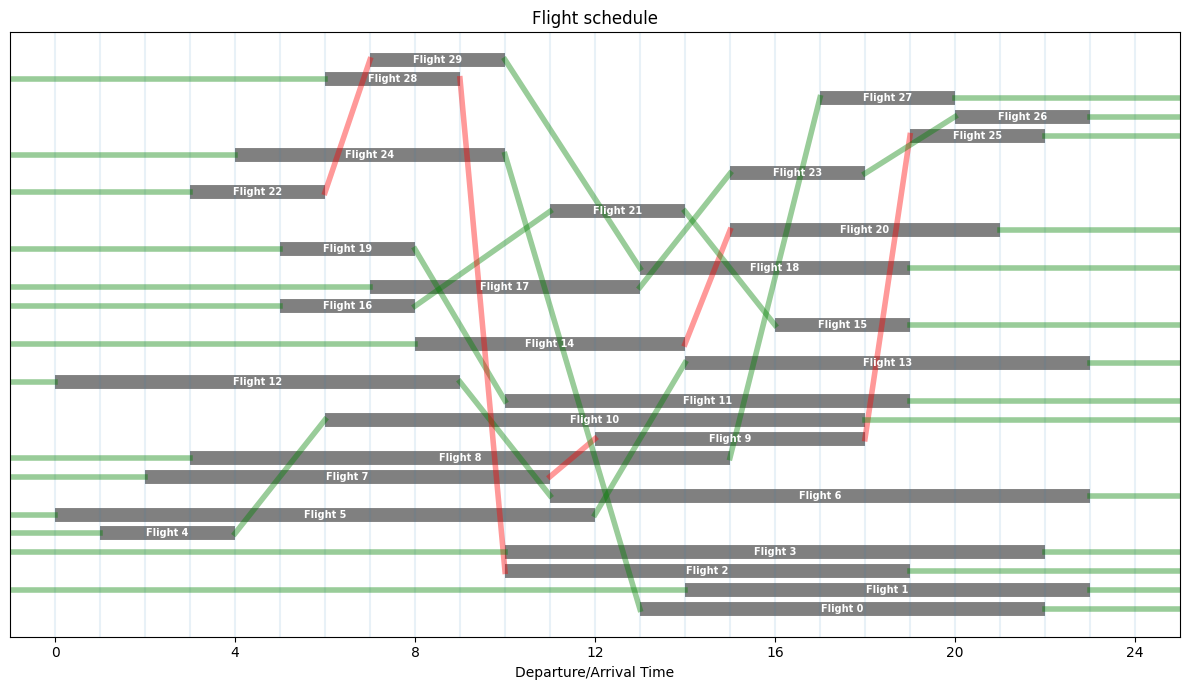

In [41]:
ax = draw_flights(FlightData)
for flight1, flight2 in flight_pairs:
    if m.x[flight1, flight2]() == 1:
        arr = FlightData.loc[flight1, "Arrival"]
        dep = FlightData.loc[flight2, "Departure"]
        c = "r" if dep - arr <= min_time else "g"
        ax.plot([arr, dep], [flight1, flight2], color=c, lw=4, alpha=0.4)

for flight in FlightData.index:
    if m.p[flight]() == 1:
        dep = FlightData.loc[flight, "Departure"]
        ax.plot([-1, dep], [flight] * 2, "g", lw=4, alpha=0.4)
    if m.q[flight]() == 1:
        arr = FlightData.loc[flight, "Arrival"]
        ax.plot([arr, 25], [flight] * 2, "g", lw=4, alpha=0.4)

plt.tight_layout()
plt.show()

## Create Flight and Aircraft Schedules

* **Flight Schedule**: A table index by flight numbers showing the assigned aircraft, departure, and arrival times.
* **Aircraft Schedule**: A table indexed by aircraft and flights showing departure and arrival times. 

In [42]:
FlightSchedule = FlightData.copy()

# create a generator of aircraft ids
aircraft = (f"A{n+1:02d}" for n in range(len(FlightData.index)))

# traverse each path through the graph
for f in FlightData.index:
    if m.p[f]() == 1:
        id = next(aircraft)
        FlightSchedule.loc[f, "Aircraft"] = id
        while m.q[f]() != 1:
            f = next(filter(lambda _: m.x[f, _]() == 1, out_nodes[f]))
            FlightSchedule.loc[f, "Aircraft"] = id

FlightSchedule = FlightSchedule[["Aircraft", "Departure", "Arrival"]]
display(FlightSchedule)

,Aircraft,Departure,Arrival
Flight,,,
0,A13,13,22
1,A01,14,23
2,A14,10,19
3,A02,10,22
4,A03,1,4
5,A04,0,12
6,A07,11,23
7,A05,2,11
8,A06,3,15


In [43]:
AircraftSchedule = FlightSchedule.copy()
AircraftSchedule["Flight"] = AircraftSchedule.index
AircraftSchedule = AircraftSchedule.sort_values(["Aircraft", "Departure"])
AircraftSchedule.index = pd.MultiIndex.from_frame(
    AircraftSchedule[["Aircraft", "Flight"]]
)
AircraftSchedule = AircraftSchedule[["Departure", "Arrival"]]
display(AircraftSchedule)

Departure  Arrival
Aircraft Flight                    
A01      1              14       23
A02      3              10       22
A03      4               1        4
         10              6       18
A04      5               0       12
         13             14       23
A05      7               2       11
         9              12       18
         25             19       22
A06      8               3       15
         27             17       20
A07      12              0        9
         6              11       23
A08      14              8       14
         20             15       21
A09      16              5        8
         21             11       14
         15             16       19
A10      17              7       13
         23             15       18
         26             20       23
A11      19              5        8
         11             10       19
A12      22              3        6
         29              7       10
         18             13       19
A13      24              4       10
         0              13       22
A14      28              6        9
         2              10       19

## Reducing riskiness of the schedule

We will now to keep the maximum number of flights at the optimal level, but try to minimize their riskiness. To do so, we define a slightly different MILO problem that takes the minimum number of planes `N_planes` and the minimum time between arrival and departure `min_time` in input and has the total number of risky pairs as objective function.


In [48]:
def schedule(FlightData, N_planes, min_time=1):
    pairs = feasible_flight_pairs(FlightData, min_time)

    weights = {pair: int(pairs[pair] == min_time) for pair in pairs}

    in_nodes = {flight: set() for flight in FlightData.index}
    out_nodes = {flight: set() for flight in FlightData.index}

    for flight1, flight2 in pairs.keys():
        in_nodes[flight2].add(flight1)
        out_nodes[flight1].add(flight2)

    m = pyo.ConcreteModel("Fleet Assignment - Minimize Risk")

    m.FLIGHTS = pyo.Set(initialize=FlightData.index)
    m.PAIRS = pyo.Set(initialize=pairs.keys())

    m.x = pyo.Var(m.PAIRS, domain=pyo.Binary)
    m.p = pyo.Var(m.FLIGHTS, domain=pyo.Binary)
    m.q = pyo.Var(m.FLIGHTS, domain=pyo.Binary)

    @m.Constraint(m.FLIGHTS)
    def sources(m, flight):
        return m.p[flight] + sum(m.x[_, flight] for _ in in_nodes[flight]) == 1

    @m.Constraint(m.FLIGHTS)
    def sinks(m, flight):
        return m.q[flight] + sum(m.x[flight, _] for _ in out_nodes[flight]) == 1

    @m.Constraint()
    def minimize_airplanes(m):
        return pyo.summation(m.p) <= N_planes

    @m.Objective(sense=pyo.minimize)
    def minimize_risk(m):
        return sum(m.x[pair] * weights[pair] for pair in m.PAIRS)

    return m

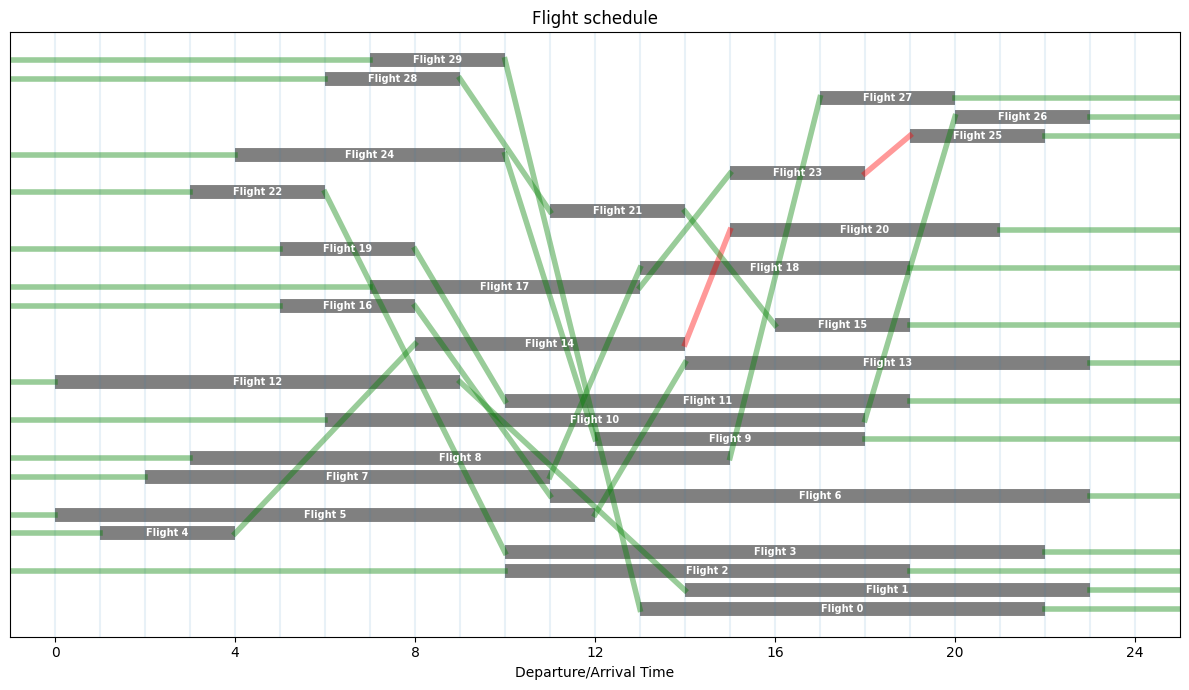

In [45]:
min_time = 1
N_planes = 14

m = schedule(FlightData, N_planes, min_time)
SOLVER.solve(m)

pairs = feasible_flight_pairs(FlightData, min_time)
ax = draw_flights(FlightData)
for flight1, flight2 in pairs.keys():
    if m.x[flight1, flight2]() == 1:
        arr = FlightData.loc[flight1, "Arrival"]
        dep = FlightData.loc[flight2, "Departure"]
        c = "r" if dep - arr <= min_time else "g"
        ax.plot([arr, dep], [flight1, flight2], color=c, lw=4, alpha=0.4)

for flight in FlightData.index:
    if m.p[flight]() == 1:
        dep = FlightData.loc[flight, "Departure"]
        ax.plot([-1, dep], [flight] * 2, "g", lw=4, alpha=0.4)
    if m.q[flight]() == 1:
        arr = FlightData.loc[flight, "Arrival"]
        ax.plot([arr, 25], [flight] * 2, "g", lw=4, alpha=0.4)
plt.tight_layout()
plt.show()

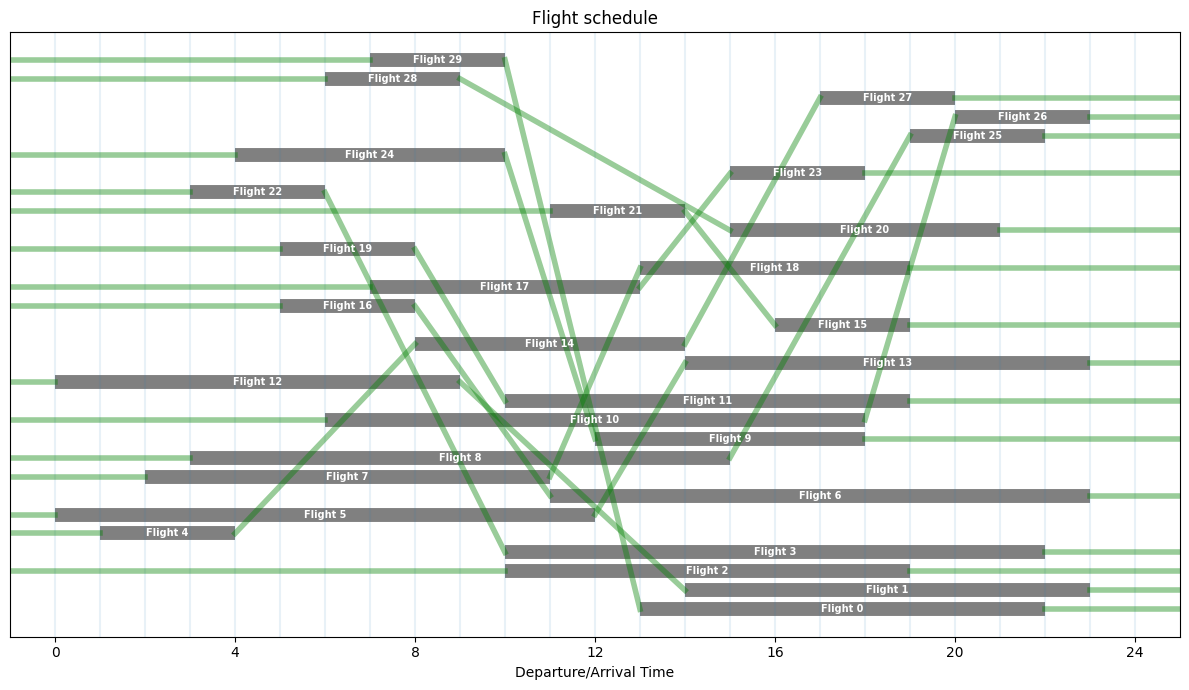

In [46]:
min_time = 1
N_planes = 15

m = schedule(FlightData, N_planes, min_time)
SOLVER.solve(m)

pairs = feasible_flight_pairs(FlightData, min_time)
ax = draw_flights(FlightData)
for flight1, flight2 in pairs.keys():
    if m.x[flight1, flight2]() == 1:
        arr = FlightData.loc[flight1, "Arrival"]
        dep = FlightData.loc[flight2, "Departure"]
        c = "r" if dep - arr <= min_time else "g"
        ax.plot([arr, dep], [flight1, flight2], color=c, lw=4, alpha=0.4)

for flight in FlightData.index:
    if m.p[flight]() == 1:
        dep = FlightData.loc[flight, "Departure"]
        ax.plot([-1, dep], [flight] * 2, "g", lw=4, alpha=0.4)
    if m.q[flight]() == 1:
        arr = FlightData.loc[flight, "Arrival"]
        ax.plot([arr, 25], [flight] * 2, "g", lw=4, alpha=0.4)
plt.tight_layout()
plt.show()

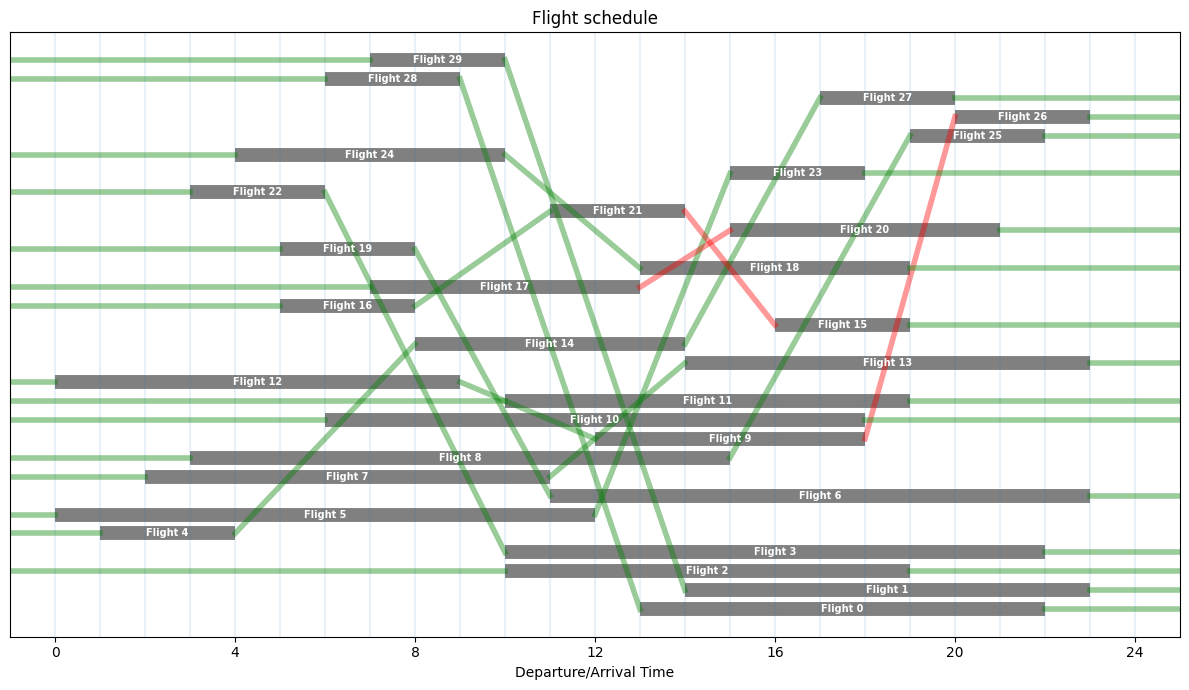

In [47]:
min_time = 2
N_planes = 15

m = schedule(FlightData, N_planes, min_time)
SOLVER.solve(m)

pairs = feasible_flight_pairs(FlightData, min_time)
ax = draw_flights(FlightData)
for flight1, flight2 in pairs.keys():
    if m.x[flight1, flight2]() == 1:
        arr = FlightData.loc[flight1, "Arrival"]
        dep = FlightData.loc[flight2, "Departure"]
        c = "r" if dep - arr <= min_time else "g"
        ax.plot([arr, dep], [flight1, flight2], color=c, lw=4, alpha=0.4)

for flight in FlightData.index:
    if m.p[flight]() == 1:
        dep = FlightData.loc[flight, "Departure"]
        ax.plot([-1, dep], [flight] * 2, "g", lw=4, alpha=0.4)
    if m.q[flight]() == 1:
        arr = FlightData.loc[flight, "Arrival"]
        ax.plot([arr, 25], [flight] * 2, "g", lw=4, alpha=0.4)
plt.tight_layout()
plt.show()